# Visualize Amazon SageMaker Training Jobs with TensorBoard for PyTorch CIFAR-10 training  



## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch. This tutorial focuses on how to create a convolutional neural network model to train the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using **PyTorch in local mode**.

### Set up the environment

This notebook was created and tested on a single ml.p2.xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [19]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"
tensorboard_logs_path = "s3://{}/{}/tensorboard_logs".format(bucket, prefix)

role = sagemaker.get_execution_role()

print(tensorboard_logs_path)

s3://sagemaker-us-east-1-062083580489/sagemaker/DEMO-pytorch-cnn-cifar10/tensorboard_logs


### Download the CIFAR-10 dataset

In [2]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 170498071/170498071 [00:01<00:00, 96739579.92it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Preview

[2023-04-19 06:28:18.251 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:55 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.24b20230214-py3.8.egg/smdebug/profiler/system_metrics_reader.py:78: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2023-04-19 06:28:19.508 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:55 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
    plane      frog       dog     truck


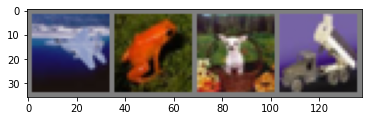

In [3]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [6]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar10")

# Construct a script for training 
Here is the full code for the network model:

In [7]:
!pygmentize source/cifar10.py

import argparse
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

try:
    from sagemaker_inference import environment
except:
    from sagemaker_training import environment

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        s

## Script Functions

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the model_fn() is called to determine how to load your trained model. The model_fn() along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* model_fn(model_dir) - loads your model.
* input_fn(serialized_input_data, content_type) - deserializes predictions to predict_fn.
* output_fn(prediction_output, accept) - serializes predictions from predict_fn.
* predict_fn(input_data, model) - calls a model on data deserialized in input_fn.

The model_fn() is the only function that doesn't have a default implementation and is required by the user for using PyTorch on SageMaker. 

## Create a training job using the sagemaker.PyTorch estimator

The `PyTorch` class allows us to run our training function on SageMaker. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. For local training with GPU, we could set this to "local_gpu".  In this case, `instance_type` was set above based on your whether you're running a GPU instance.

After we've constructed our `PyTorch` object, we fit it using the data we uploaded to S3. Even though we're in local mode, using S3 as our data source makes sense because it maintains consistency with how SageMaker's distributed, managed training ingests data.


### Save Tensors Using Debugger Built-in Collections


In [21]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, TensorBoardOutputConfig

tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=tensorboard_logs_path
)

# use Debugger CollectionConfig to call built-in collections
collection_configs=[
        CollectionConfig(name="weights"),
        CollectionConfig(name="gradients"),
        CollectionConfig(name="losses"),
        CollectionConfig(name="biases")
    ]

hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [22]:
from sagemaker.pytorch import PyTorch

cifar10_estimator = PyTorch(
    entry_point="source/cifar10.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    instance_count=1,
    instance_type="ml.c5.xlarge",
    # Debugger parameters
    debugger_hook_config=hook_config,
    tensorboard_output_config=tensorboard_output_config
)

cifar10_estimator.fit(inputs)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-19-06-52-58-861


2023-04-19 06:52:59 Starting - Starting the training job...
2023-04-19 06:53:15 Starting - Preparing the instances for training...
2023-04-19 06:53:55 Downloading - Downloading input data...
2023-04-19 06:54:25 Training - Downloading the training image...
2023-04-19 06:54:46 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-19 06:54:50,420 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-19 06:54:50,423 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-19 06:54:50,431 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-19 06:54:50,434 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-19 06:54:50,593 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
20

In [26]:
tensorboard_logs_path

's3://sagemaker-us-east-1-062083580489/sagemaker/DEMO-pytorch-cnn-cifar10/tensorboard_logs'

In [24]:
!aws s3 ls {tensorboard_logs_path}/

                           PRE pytorch-training-2023-04-19-06-52-58-861/


## TensorBoard

### Run TensorBoard inside SageMaker Notebooks

Now we can use TensorBoard to compare all training jobs, including local, cloud, tuning training. The following cell will run TensorBoard inside of the SageMaker Notebook Instance.

Start Tensorboard from the System terminal and view the Tensorboard UI. To do this, follow steps 1-3 below:

1. From SageMaker Studio's Jupyter Server, launch the System terminal (under Utilities and files)
2. Run the following command to install tensorboard onto the system terminal

```pip install tensorboard```

3. Paste the command that is the output of the next cell to start your tensorboard instance on Studio:

In [ ]:
aws_region = sagemaker_session.boto_region_name
!AWS_REGION={aws_region}
!echo tensorboard --logdir {tensorflow_logs_path}

4. Finally click the link below!

[**Click here to access TensorBoard instance**](/jupyter/default/proxy/6006/)

Instance of TensorBoard will be available at `https://<notebook instance hostname>/proxy/6006/`.
By default TensorBoard assigns port 6006, but if it's already in use TensorBoard will increase the port by 1, so 6007, 6008 and so on until it finds an available port.
